# TSAI Assignment

## Session 2.5 - PyTorch 101

1. Write a neural network that
   a. can take 2 inputs:

   1. an image from the MNIST dataset (say 5), and
   2. a random number between 0 and 9, (say 7)

   b. and gives 2 outputs:

   1. the "number" that was represented by the MNIST image (predict 5), and
   2. the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)

2. You can mix fully connected layers and convolution layers

3. You can use one-hot encoding to represent the random umber input as well as the "summed" output.

4. **Your code MUST be** - well documented (via readme file on github and comments in the code) - must mention the data representation - must mention your data generation strategy (basically the class/method you are using for random number generation) - must mention how you have combined the two inputs (basically which layer you are combining) - must mention how you are evaluating your results - must mention "what" results you finally got and how did you evaluate your results - must mention what loss function you picked and why!

5. Training MUST happen on the PU

6. Accuracy is not really important for the UM

7. Once done, upload the code with short trining logs in the readme file from colab to GitHub, and share the GitHub lik (public repository

In [65]:
from tqdm import tqdm

import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import torch
import numpy as np
from torchsummary import summary
import os
os.makedirs('/results/', exist_ok =True)

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
def get_binary(n):
    return [1 if(each>0.5) else 0 for each in n]

class CustomRandDataset(Dataset):
  def __init__(self, mnist_data, is_train=True):
    if(is_train):
      self.rand_number_data = torch.randint(low=0, high=9, size=(60000, ))
    else:
      self.rand_number_data = torch.randint(low=0, high=9, size=(10000, ))
    
    self.mnist_data = mnist_data

    # prepare one hot encoded - data & labels
    self.encoded_rand_number_data = F.one_hot(self.rand_number_data, num_classes=10)

    self.data = []
    self.labels = []

    for ((mnist_data, mnist_label), rand_number) in tqdm(zip(self.mnist_data, self.rand_number_data)):
      encoded_rand_number = F.one_hot(rand_number, num_classes=10)
      self.data.append(torch.cat((torch.tensor(mnist_data), encoded_rand_number), 0))
      
      sum = mnist_label + rand_number
      encoded_mnist_label = F.one_hot(torch.tensor(mnist_label), num_classes=10)
      encoded_sum = F.one_hot(sum, num_classes=19)
      self.labels.append(torch.cat((encoded_mnist_label, encoded_sum), 0))

    print("len(self.data) = ", len(self.data))
    print("len(self.labels) = ", len(self.labels))
  
  
  def __getitem__(self, index):
    return self.data[index], self.labels[index]

  def __len__(self):
    return len(self.data)

mnist_train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                  T.Lambda(lambda x: torch.flatten(x)),
                                  T.Lambda(lambda x: np.array(get_binary(x))),
                                  ]))

mnist_test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                  T.Lambda(lambda x: torch.flatten(x)),
                                  T.Lambda(lambda x: np.array(get_binary(x))),
                               ]))

train_loader = torch.utils.data.DataLoader(CustomRandDataset(mnist_data=mnist_train_dataset, is_train=True), 
                                                batch_size=batch_size_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(CustomRandDataset(mnist_data=mnist_test_dataset, is_train=False), 
                                               batch_size = batch_size_test, shuffle=False)


In [93]:
for x,y in train_loader:
  print(x.shape, y.shape)
  print(y[0])
  break

for x,y in test_loader:
  print(x.shape,y.shape)
  break

torch.Size([64, 794]) torch.Size([64, 29])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0])
torch.Size([1000, 794]) torch.Size([1000, 29])


In [74]:
class Network(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_classes=29):
        super(Network, self).__init__()
        
        self.layer = nn.Sequential(
            # in_channels=794, out_channels=1, kernel_size=3, stride=1
            nn.Conv1d(in_channels=in_channels, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(1, affine=True),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(1, affine=True),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(1, affine=True),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(1, affine=True),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=2, padding=1, bias=True),
        ) 
        self.fc = nn.Linear(7*7*32, num_classes)
        self.fc = nn.Linear(25, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

In [90]:
network = Network()
print(network)

optimizer = optim.SGD(network.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)
lossF = nn.BCELoss()


train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]


def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = torch.unsqueeze(data, 1).type(torch.float)
        output = network(data)
        new_output = torch.tensor([[1 if element>0.5 else 0 for element in each] for each in output], dtype=torch.float)
        loss = lossF(output, target.type(torch.float))
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = torch.unsqueeze(data, 1).type(torch.float)
            output = network(data)
            new_output = torch.tensor([[1 if element>0.5 else 0 for element in each] for each in output], dtype=torch.float)
            test_loss += lossF(output, target.type(torch.float)).item()

            for x,y in zip(new_output, target):
              if(all(torch.eq(x, y))):
                correct += 1

    print(correct)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Network(
  (layer): Sequential(
    (0): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
  )
  (fc): Linear(in_features=25, out_features=29, bias=True)
  (sigmoid): Sigmoid()
)
Train Epoch: 1 [0/60000 (0%)]	

Text(0, 0.5, 'negative log likelihood loss')

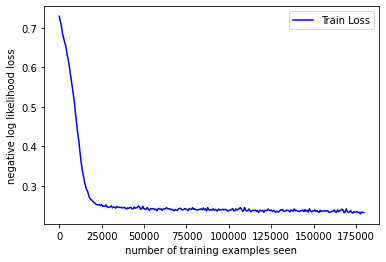

In [91]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:

# fig = plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i+1)
#     plt.tight_layout()
#     plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Prediction: {}".format(
#         output.data.max(1, keepdim=True)[1][i].item()))
#     plt.xticks([])
#     plt.yticks([])
# fig
